# Prédiction de l'impact de sanctions économiques

# Notebook 1 - Modèle "naïf" (pas de feature engineering)

#### Data preparation

In [2]:
# import required libraries

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 80)
sns.set_style("whitegrid")
%matplotlib inline

np.random.seed(0)
seed=42

In [3]:
base_df = pd.read_csv("input/sanctions.csv.gz", index_col=0, na_values="n.a.", decimal=",")

base_df.columns

Index(['Sender c', 'Sender 2c', 'Sender 3c', 'Targetd', 'Goal', 'US casee',
       'US unilateral casef', 'Foreign policy goal categoryg', 'First yearh',
       'Last yeari', 'Policy resultj', 'Sanctions contributionk',
       'Success \nscorel', 'Companion policiesm', 'International cooperationn',
       'International assistanceo', 'Cooperating international organizationp',
       'International organization senderq',
       'International organization sender & target membersr',
       'Length (years)s', 'Prior relationst',
       'Regime Type \n(DEMOC 1st year)u', 'Regime Type2 (Polity2 1st year)v',
       'Regime Type3 \n(Scale 1st year)w', 'Political stability priorx',
       'Political stability duringy', 'Cost to targetz',
       'Cost to target (percent of GNP)aa', 'Cost to target per capitabb',
       'Trade linkagecc', 'GNP \nratiodd', 'Health and stabilityee',
       'Sanction typeff', 'Cost to sendergg',
       'GDP growth (percent, 5-year average)hh',
       'Inflation (pe

In [4]:
# Rename columns for clarity

clean_names = [
    'Sender1', 'Sender2', 'Sender3', 'Target', 'Goal', 'US case',
    'US unilateral case', 'Foreign policy goal category', 'First year',
    'Last year','Policy result', 'Sanctions contribution',
    'Success', 'Companion policies', 'International cooperation',
    'International assistance', 'Cooperating international organization',
    'International organization sender',
    'International organization sender & target members',
    'Length', 'Prior relations',
    'Regime Type1', 'Regime Type2',
    'Regime Type3', 'Political stability prior',
    "Political stability during", 'Cost to target',
    'Cost to target GNP pct', 'Cost to target per capita',
    'Trade linkage', 'GNP ratio','Health and stability',
    'Sanction type', 'Cost to sender',
    'GDP growth',
    'Inflation',
    'Target IMF code',
    'Country group']

name_dict = dict(zip(base_df.columns, clean_names))
base_df = base_df.rename(columns=name_dict)

In [5]:
# Drop certain columns
# - information unknown at decision time
# - calculated components of success
# - information useless for prediction

unknowns = [
    "Last year",
    "Length",
    "Political stability during",
    "Cost to target",
    "Cost to target GNP pct",
    "Cost to target per capita",
    "Cost to sender"]
calculated = ["Policy result", "Sanctions contribution"]
useless = ["Target IMF code"]

df = base_df.drop(unknowns, axis=1)
df = df.drop(calculated, axis=1)
df = df.drop(useless, axis=1)

print(df.shape)
df.head(3)

(204, 28)


,Sender1,Sender2,Sender3,Target,Goal,US case,US unilateral case,Foreign policy goal category,First year,Success,Companion policies,International cooperation,International assistance,Cooperating international organization,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,Inflation,Country group
Case no.b,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14-1,UNITED KINGDOM,NaN,NaN,GERMANY,Military victory,0,0,4,1914,12,R,4,A,--,0,0,1,5.0,2.0,2.0,0.0,9.0,1.0,3,"F,X,M",3.6,2.9,1
17-1,UNITED STATES,NaN,NaN,JAPAN,Shipping for Allies,1,1,5,1917,4,--,1,--,--,0,0,2,5.0,1.0,2.0,0.0,20.5,13.0,3,X,5.4,25.6,1
18-1,UNITED KINGDOM,NaN,NaN,RUSSIA,Destabilize Bolsheviks,0,0,2,1918,2,"R,Q",4,--,--,0,0,1,1.0,-1.0,2.0,0.1,18.5,1.0,1,"F,X,M",NaN,NaN,2


#### Data cleaning

In [6]:
# drop all not immediately useful columns

useless = ["Sender1", "Sender2", "Sender3", "Target", "Goal", "Country group"]
df = df.drop(useless, axis=1)

In [7]:
# Create helpers

def replace_w_dummies(dataframe, col_name, prefx):
    """Get dummy columns for a given dimension"""
    new_dataframe = pd.concat([dataframe, pd.get_dummies(df[col_name], prefix=prefx)], axis=1)
    new_dataframe.drop([col_name], axis=1, inplace=True)
    return new_dataframe


def year_to_era(yr):
    """Convert years into era"""
    yr = int(yr)
    if yr < 1945:
        return 1
    elif yr < 1991:
        return 2
    else:
        return 3

In [8]:
# Clean

df = replace_w_dummies(df, 'Foreign policy goal category', 'frgn_pol_')

df['International assistance'] = df['International assistance'].apply(lambda x: 0 if x == "--" else 1)

df["first-year_era"] = df["First year"].apply(year_to_era)
df = df.drop(["First year"], axis=1)

df["bool_success"] = 1 * (df["Success"] >= 9)
df.drop(["Success"], axis=1, inplace=True)

# Convert "Companion policies"
def rate_comp_policies(letters):
    s = 0
    if letters.find("J") >= 0:
        s += 1
    if letters.find("Q") >= 0:
        s += 1
    if letters.find("R") >= 0:
        s += 1
    return s
df["Companion policies"] = df["Companion policies"].apply(rate_comp_policies)

# Convert "Sanction type"
def rate_sanction_type(letters):
    s = 0
    if letters.find("F") >= 0:
        s += 1
    if letters.find("X") >= 0:
        s += 1
    if letters.find("M") >= 0:
        s += 1
    return s
df["Sanction type"] = df["Sanction type"].apply(rate_sanction_type)

# Make "Cooperating international organization" 1 or 0
df["bool_Cooperating international organization"] = df["Cooperating international organization"].apply(lambda x: 0 if x == "--" else 1)
df.drop(["Cooperating international organization"], axis=1, inplace=True)

In [9]:
df.head(10)

,US case,US unilateral case,Companion policies,International cooperation,International assistance,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,Inflation,frgn_pol__1,frgn_pol__2,frgn_pol__3,frgn_pol__4,frgn_pol__5,first-year_era,bool_success,bool_Cooperating international organization
Case no.b,,,,,,,,,,,,,,,,,,,,,,,,,,
14-1,0,0,1,4,1,0,0,1,5.0,2.0,2.0,0.0,9.0,1.0,3,3,3.6,2.9,0,0,0,1,0,1,1,0
17-1,1,1,0,1,0,0,0,2,5.0,1.0,2.0,0.0,20.5,13.0,3,1,5.4,25.6,0,0,0,0,1,1,0,0
18-1,0,0,2,4,0,0,0,1,1.0,-1.0,2.0,0.1,18.5,1.0,1,3,NaN,NaN,0,1,0,0,0,1,0,0
21-1,0,0,0,4,0,1,1,2,3.0,0.0,2.0,0.4,26.5,37.0,2,0,-1.5,NaN,0,0,1,0,0,1,1,0
25-1,0,0,0,4,0,1,1,2,0.0,-6.0,1.0,0.9,36.0,56.0,2,0,3.3,48.8,0,0,1,0,0,1,1,0
32-1,0,0,0,3,0,1,1,2,4.0,2.0,2.0,0.0,63.0,322.0,2,1,NaN,NaN,0,0,1,0,0,1,0,0
32-1,0,0,0,3,0,1,1,2,1.0,-3.0,2.0,0.0,59.5,735.0,2,1,NaN,NaN,0,0,1,0,0,1,0,0
33-1,0,0,0,1,0,0,0,1,0.0,-9.0,1.0,0.0,13.0,1.0,2,1,2.4,NaN,1,0,0,0,0,1,1,0
35-1,0,0,0,4,1,1,1,2,0.0,-9.0,1.0,0.3,16.0,6.0,3,3,-0.5,-4.4,0,0,1,0,0,1,0,0


#### Handling missing values

In [10]:
df7 = df

df7.isna().sum()

US case                                                0
US unilateral case                                     0
Companion policies                                     0
International cooperation                              0
International assistance                               0
International organization sender                      0
International organization sender & target members     0
Prior relations                                        0
Regime Type1                                           5
Regime Type2                                           5
Regime Type3                                           5
Political stability prior                              5
Trade linkage                                          1
GNP ratio                                              0
Health and stability                                   0
Sanction type                                          0
GDP growth                                            18
Inflation                      

#### Reminder:
- Regime Type is the value of the Polity IV variable called DEMOC, which measures the degree of democracy in the target in the 1st year of sanctions, ranging from 0 (no democracy) to 10 (strong democracy)
- Regime Type2 is the value of the Polity2 variable from the Polity IV database that allows for a country to have varying degrees of both democracy and autocracy in the target, ranging from -10 (strongly autocratic) to 10 (strongly democratic)
- Regime Type3 collapses the Polity2 data to a 3-point scale where 1 = autocracy, 2 = anocracy, and 3 = democracy.

In [11]:
#  !!! A DISCUTER !!!

# Replace NAN by mean value
df7 = df.apply(lambda x: x.fillna(np.round(x.mean(),1)), axis=0)

In [12]:
# change type to float64 for all columns
df7 = df7.astype(np.float64)

In [13]:
df7.head(3)

,US case,US unilateral case,Companion policies,International cooperation,International assistance,International organization sender,International organization sender & target members,Prior relations,Regime Type1,Regime Type2,Regime Type3,Political stability prior,Trade linkage,GNP ratio,Health and stability,Sanction type,GDP growth,Inflation,frgn_pol__1,frgn_pol__2,frgn_pol__3,frgn_pol__4,frgn_pol__5,first-year_era,bool_success,bool_Cooperating international organization
Case no.b,,,,,,,,,,,,,,,,,,,,,,,,,,
14-1,0.0,0.0,1.0,4.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,0.0,9.0,1.0,3.0,3.0,3.6,2.9,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
17-1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,1.0,2.0,0.0,20.5,13.0,3.0,1.0,5.4,25.6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
18-1,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,-1.0,2.0,0.1,18.5,1.0,1.0,3.0,3.2,98.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Modelization

In [14]:
# Split dataset into train / test sets

Y = df7['bool_success']
X = df7.drop(['bool_success'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=Y)

print("Train size", x_train.shape[0])
print("Test size", x_test.shape[0])
print("Number of parameters", x_train.shape[1])

Train size 163
Test size 41
Number of parameters 25


In [15]:
# Create pipelines for modelization, and define hyperparameters to be used.

# Pipelines 

pipelines = {
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state = seed)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = seed)),
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1', random_state=seed, solver='saga', max_iter=300)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', random_state=seed, solver='saga', max_iter=300))}

# Hyperparameters

rf__hyperparameters = {
    'randomforestclassifier__n_estimators' : [100, 200],
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf' : [1, 3, 5, 10]
}

gb__hyperparameters = {
    'gradientboostingclassifier__n_estimators' : [100, 200],
    'gradientboostingclassifier__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth' : [1, 3, 5, 10]
}

l1__hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2__hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

hyperparameters = { 
    'rf' : rf__hyperparameters,
    'gb' : gb__hyperparameters,
    'l1' : l1__hyperparameters,
    'l2' : l2__hyperparameters
}

In [16]:
# Create models for all the hyper-parameters combinations

models = {}

for name, pipeline in pipelines.items() :    
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1, iid=False)      
    model.fit(x_train, y_train)    
    models[name] = model     
    print(f'{name} has been fitted')

rf has been fitted
gb has been fitted
l1 has been fitted
l2 has been fitted


In [17]:
# Evaluation performance
# => show accuracy (other metrics will be needed) for each model

for key in models.keys():
    train_preds = models[key].predict(x_train)
    test_preds = models[key].predict(x_test)
    train_accuracy = np.round(metrics.accuracy_score(y_train, train_preds),2)
    test_accuracy = np.round(metrics.accuracy_score(y_test, test_preds),2)
    print("Accuracy for" ,key ,"on train:", train_accuracy,"and on test:", test_accuracy)

Accuracy for rf on train: 1.0 and on test: 0.66
Accuracy for gb on train: 0.82 and on test: 0.66
Accuracy for l1 on train: 0.75 and on test: 0.68
Accuracy for l2 on train: 0.77 and on test: 0.71


## Exploration of errors

In [18]:
def print_metrics(model, y, x, label='model name', best_estimator=False):
   
    preds = model.predict(x)
        
    print(f'Confusion matrix for {label} :')
    
    if best_estimator == True:
        print(model.best_estimator_)
        
    print('Accuracy', np.round(metrics.accuracy_score(y, preds),2))
    
    m=metrics.confusion_matrix(preds,y)
    
    #si on a envie d'avoir le pourcetage
    #p=np.round(np.divide(m, y.shape[0]) *100, 1)
    
    ax = sns.heatmap(m, annot=True, fmt='.0f', cbar=False, cmap="Blues", yticklabels=['Success','Fail'], xticklabels=['Success','Fail'])
    ax.set(xlabel='Predicted', ylabel='True')
    plt.show()

Confusion matrix for l2 :
Accuracy 0.71


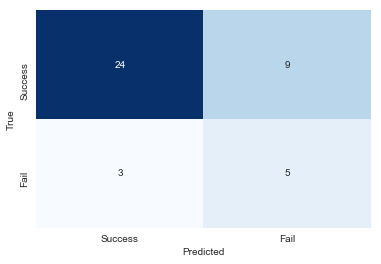

In [19]:
print_metrics(models['l2'], y_test, x_test, label='l2')

### Correlation

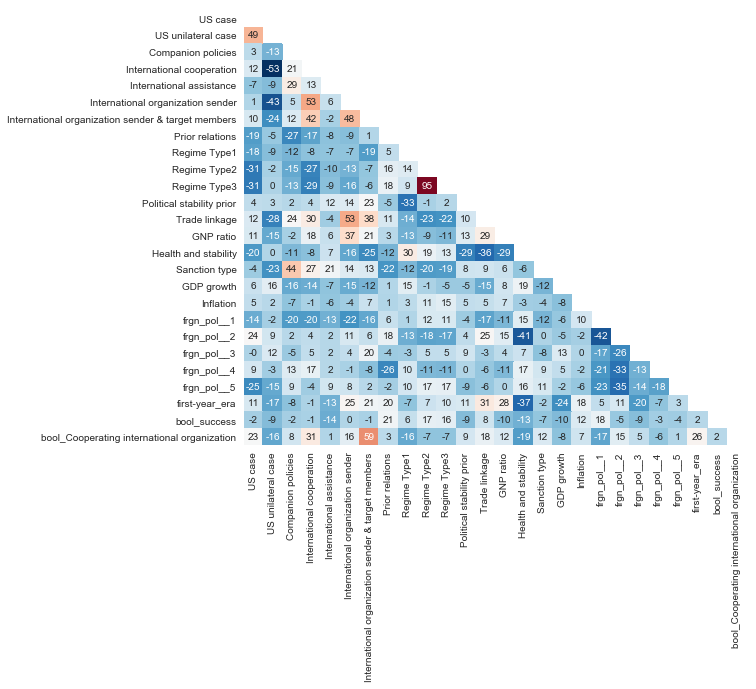

In [20]:
correlations = df7.corr() * 100

cleanning_mask = np.zeros_like(correlations)
upper_triangle = np.triu_indices_from(correlations)
cleanning_mask[upper_triangle] = 1

plt.figure(figsize=(9,8))

sns.heatmap(correlations, cmap = 'RdBu_r', mask = cleanning_mask, annot=True, fmt='.0f', cbar=False )

### Choix des variables qui corrèlent le plus avec bool_success

In [21]:
corr_level = 10

# Correlation with output variable
cor_target = abs(correlations["bool_success"])

# Selecting highly correlated features
correlated_features = cor_target[cor_target>corr_level]
correlated_features

International assistance     14.132749
Prior relations              20.904206
Regime Type2                 16.520583
Regime Type3                 15.846804
Health and stability         13.280366
GDP growth                   10.084554
Inflation                    12.241471
frgn_pol__1                  18.341120
bool_success                100.000000
Name: bool_success, dtype: float64

In [22]:
correlated=correlated_features.index.to_list()
correlated.remove('bool_success')

### Reffiting de modèle avec les feautures séléctionnés

In [23]:
correlated_models = {}

for name, pipeline in pipelines.items() :
    
    model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=-1, iid=False)      
    model.fit(x_train[correlated], y_train)
    
    correlated_models[name] = model     
    print(f'{name} has been fitted')

rf has been fitted
gb has been fitted
l1 has been fitted
l2 has been fitted


In [24]:
for key in models.keys():
    train_preds = correlated_models[key].predict(x_train[correlated])
    test_preds = correlated_models[key].predict(x_test[correlated])
    train_accuracy = np.round(metrics.accuracy_score(y_train, train_preds),2)
    test_accuracy = np.round(metrics.accuracy_score(y_test, test_preds),2)
    print("Accuracy for" ,key ,"on train:", train_accuracy,"and on test:", test_accuracy)

Accuracy for rf on train: 0.73 and on test: 0.63
Accuracy for gb on train: 0.73 and on test: 0.66
Accuracy for l1 on train: 0.72 and on test: 0.59
Accuracy for l2 on train: 0.72 and on test: 0.59


# To do now :

- Interprétation du modèle :
1) mieux comprendre les performances (ROC?)
2) quelles sont les features les plus importantes ?

- Amélioration : feature engineering
    - Ne pas être trop ambitieux
    - Reprendre nos notes